In [1]:
# Imports

import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rfcnt

In [2]:
# Some helper functions

def dh_from_tp(
    tp: np.ndarray,
    length: int = None
) -> np.ndarray:
    """
    Calculate the damage history from turning points information.

    Parameters
    ----------
    tp : array
        Matrix containing turning points information.
        tp[:, 0] - array of indices (1-based)
        tp[:, 1] - array of values associated with indices (not used directly)
        tp[:, 2] - array of damages to distribute

    length : int, optional
        Length of the damage history array.
        If None, it is determined from tp.
        Defaults to None.

    Returns
    -------
    dh : np.ndarray
        Damage history array where dh[index-1] contains the accumulated damage at each index.

    Notes
    -----
    - Indices in tp are assumed to be 1-based (typical in many numerical applications).
    - This function assumes that indices in tp[0] are non-decreasing.
    - The returned array dh has a length of 'length', where the damage values from tp are distributed accordingly.
    - If 'length' is provided, it should be greater than or equal to the maximum index in tp[0].
    - If 'length' is not provided, it is inferred from the maximum index present in tp[0].
    """
    if length is None:
        length = np.max(tp[0])  # indices are base 1!
    assert length >= np.max(tp[:, 0])

    dh = np.zeros(shape=length, dtype=np.double)

    # Distribute partial damages from turning points over time
    dh[tp[:, 0].astype(int) - 1] = tp[:, 2]

    return dh


def inspect_rfc(
    data: rfcnt.ArrayLike,
    class_params: rfcnt.ClassParams
) -> Tuple[List[tuple], int, float, float]:
    """
    Perform rainflow counting with standard arguments.

    Parameters
    ----------
    data : rfcnt.ArrayLike
        Input data for rainflow counting.
    classs_params : rfcnt.ClassParams
        Count, offset and width of classes used for rainflow counting.

    Returns
    -------
    tuple
        Tuple containing the results of rainflow counting:
        - cycles (list of tuples): List of rainflow cycles identified in the data.
        - class_count (int): Number of classes for rainflow counting.
        - class_offset (float): Class range data offset for rainflow counting.
        - class_width (float): Width of each class for rainflow counting.

    Notes
    -----
    - Standard arguments such as class_count, class_offset, and class_width are used for rainflow counting.
    - Other parameters like hysteresis, spread_damage, residual_method, and wl (window length) are set to specific values
      for the rainflow counting algorithm.
    """
    # Perform rainflow counting with specified parameters
    return rfcnt.rfc(
        data,
        **class_params._asdict(),
        hysteresis=class_params.class_width,  # hysteresis set to class_width
        spread_damage=rfcnt.SDMethod.FULL_P2,  # assign damage for closed cycles to 2nd turning point
        residual_method=rfcnt.ResidualMethod._NO_FINALIZE,  # don't consider residues and leave internal sequence open
        wl={"sd": 1e3, "nd": 1e7, "k": 5},  # window length parameters
    )


def inspect_sequence(
    data: rfcnt.ArrayLike,
    class_params: rfcnt.ClassParams,
    max_len: int = 0
) -> Tuple[Tuple, np.ndarray]:
    """
    Inspect the damage history by applying rainflow counting successively for one more data point at a time.

    Parameters
    ----------
    data : rfcnt.ArrayLike
        Input data for rainflow counting.
    classs_params : rfcnt.ClassParams
        Count, offset and width of classes used for rainflow counting.
    max_len : int, optional
        Maximum length to consider for the sequence inspection.
        Defaults to 0, which means inspecting the entire data length.

    Returns
    -------
    tuple
        Tuple containing:
        - Tuple from inspect_rfc function with full data.
        - Array representing cumulative damage at each point in the sequence inspection.

    Notes
    -----
    - This function iteratively applies rainflow counting to `data` with increasing length from 1 to `max_len` (or full length if max_len is 0).
    - `seq_damage` array records the accumulated damage at each step of the inspection.
    - The assertion checks if the total damage calculated by rainflow counting matches the sum of damages attributed to turning points (`tp`).
    - At this point of view, damage accumulated until to `i` is attributed to the datapoint at `i`, which is neither P2, nor P3!
      This is noticeable in that the course of the line shows an apparent latency.
    """
    seq_damage = np.zeros(shape=data.size)  # Initialize sequence damage array

    for i in range(len(data)):
        # Perform rainflow counting on data from indices 0 to i (inclusive)
        res = inspect_rfc(data[:i + 1], class_params)

        # Assertion to ensure all damage is distributed over turning points
        if not np.isclose(res["tp"][:, 2].sum(), res["damage"], rtol=1e-10):
            assert False  # This should not occur: Damage should be entirely distributed over turning points

        # Record accumulated damage at index i
        seq_damage[i] = res["damage"]

    # Return results from inspect_rfc on full data and cumulative damage array
    return inspect_rfc(data, class_params), seq_damage

In [3]:
# Load data series

data = pd.read_csv(os.path.join("../tests/", "long_series.csv"), header=None)
data = data.to_numpy().squeeze()

class_count = 50
class_range = data.ptp()
class_width = class_range / (class_count - 1)
class_offset = data.min() - class_width / 2
class_params = rfcnt.ClassParams(class_count, class_offset, class_width)

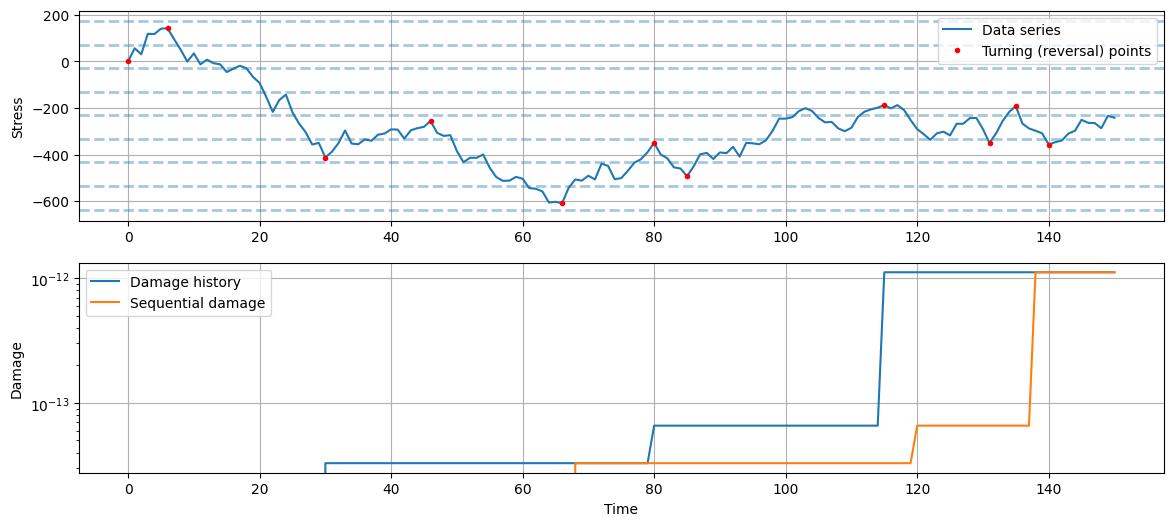

In [4]:
# Get a close look at the first 150 data points

chunk = data[:151]
res, seq = inspect_sequence(
    data=chunk,
    class_params = class_params
)

_, ax = plt.subplots(2, 1, figsize=(14, 6))

for i in range(class_count + 1):
    ax[0].axhline(class_offset + i * class_width, ls="--", lw=2, color="C0", alpha=0.4)
ax[0].plot(chunk, label="Data series")
ax[0].plot(
    res["tp"][:, 0] - 1,
    res["tp"][:, 1],
    "ro",
    markersize=3,
    label="Turning (reversal) points",
)
ax[0].set_ylabel("Stress")
ax[0].grid(True, which="both")
ax[0].set_ylim(chunk.min() - chunk.ptp() * 0.1, chunk.max() + chunk.ptp() * 0.1)
ax[0].legend(loc=1)

ax[1].semilogy(np.cumsum(res["dh"]), label="Damage history")
ax[1].semilogy(seq, label="Sequential damage")
ax[1].set_ylabel("Damage")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

plt.show()

Original data shape: (10001,)
Data shape of `dh` (10001,)


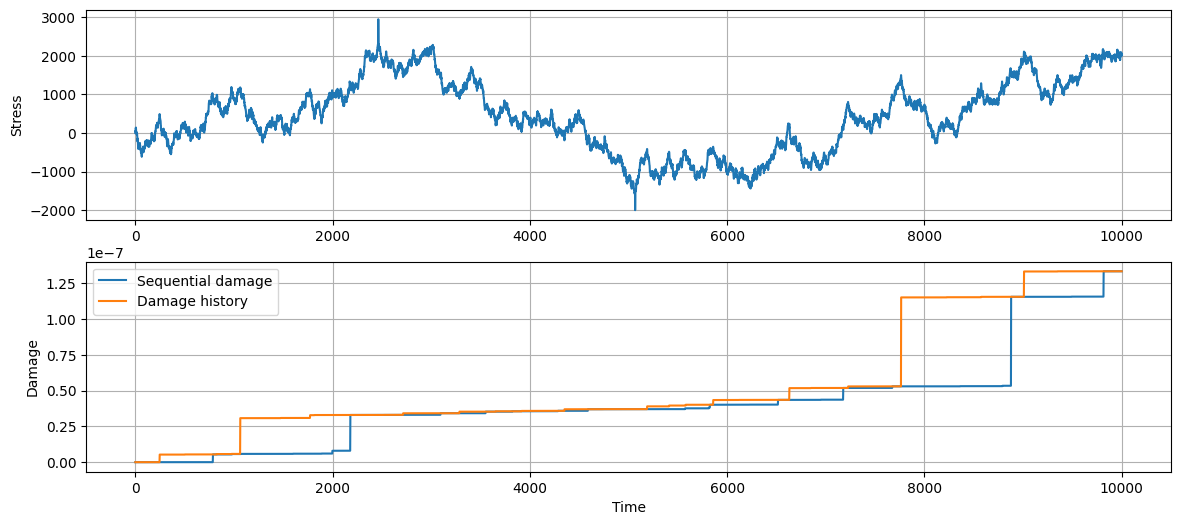

In [5]:
# Inspect entire data

res, seq = inspect_sequence(data, class_params)

print("Original data shape:", data.shape)
print("Data shape of `dh`", res["dh"].shape)

# Sanity check for damage history: Compare with reconstruction from turning points
assert np.isclose(res["dh"], dh_from_tp(res["tp"], res["dh"].size), rtol=1e-10).all()

fig, axs = plt.subplots(2, 1, figsize=(14, 6))
axs[0].plot(data, label="Data series")
axs[0].grid(True, which="both")
axs[0].set_ylabel("Stress")

axs[1].plot(seq, label="Sequential damage")
axs[1].plot(np.cumsum(res["dh"]), label="Damage history")

axs[1].grid(True, which="both")
axs[1].set_ylabel("Damage")
axs[1].set_xlabel("Time")
axs[1].legend(loc="best")

plt.show()